In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import collections
import pandas as pd

from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


**Loading the dataset (matlab dictionary)**

In [2]:
def loadMatFile(file_path, file_name, key):
    """
    Load a mat file and return an item of the dictionary loaded.
    """    
    # read mat file dictionary
    dictionary = scipy.io.loadmat(file_path + file_name)
    
    # access item of a dictionary
    array = dictionary[key]
    
    return array

In [3]:
# Load hologram dataset
path = 'C:\\Users\\flucasamar\\Desktop\\Github\\computerGeneratedHolography\\'
file_path = path + '\\output\\dataset\\'

file_name = 'hDataset.mat'
key = 'hDataset'

# Load dictionary
dat = loadMatFile(file_path, file_name, key)
print(dat.shape)

# Number of holograms
nb_holograms = dat.shape[2]

# Number of class
nb_class = 5

# Number of holograms per class
nb_holograms_class = int(nb_holograms/nb_class)

print('Total number of holograms: ' + str(nb_holograms))
print('Number of holograms per class: ' + str(nb_holograms_class))

(200, 200, 1500)
Total number of holograms: 1500
Number of holograms per class: 300


<class 'numpy.complex128'>


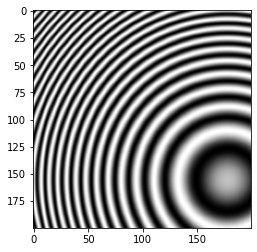

In [4]:
# Plot an example
hol = dat[:,:,0]
print(type(hol[0,0]))

plt.imshow(np.real(hol), cmap = 'gray')
plt.show()

**Data pre-processing**

Reshape dataset

In [5]:
# Dimension
rows = dat.shape[0]
columns = dat.shape[1]

# Reshape the dataset so that the first dimension is the number of holograms
dat_r = np.ones([nb_holograms, rows, columns], dtype = complex)
print(dat_r.shape)

for i in range(nb_holograms):
    dat_r[i,:,:] = dat[:,:,i]

(1500, 200, 200)


Normalizing the matrix

In [6]:
def normalize(arr):
    max_value = np.max(np.max(arr, axis = 0))
    min_value = np.min(np.min(arr, axis = 0))
    arr = (arr - min_value) / (max_value - min_value)
    return arr

In [7]:
%%time
# Normalize the data
dat_norm = np.zeros([nb_holograms, rows, columns], dtype = complex)

# Normalize each hologram
for i in range(nb_holograms):
    dat_norm[i,:,:] = normalize(dat_r[i,:,])
print(dat_norm.shape)

(1500, 200, 200)
Wall time: 2.16 s


Compute targets

In [8]:
# Compute array of targets
Y_array = np.ones([nb_holograms,])

pos = 0
for c in range(nb_class):
    for h in range(nb_holograms_class):
        Y_array[pos] = c
        pos = pos + 1

# Verify
print(Y_array.shape)
print(collections.Counter(Y_array))

(1500,)
Counter({0.0: 300, 1.0: 300, 2.0: 300, 3.0: 300, 4.0: 300})


Split the dataset in trainset and testset

In [9]:
# Dataset
X_array = dat_norm

# Number of examples
m = nb_holograms

# Split our data in two subsets: training set (80%) and testing set (20%)
m_train = int(m*0.8)
m_test = m - m_train

X_train = np.zeros([m_train, rows, columns, ], dtype = complex)
Y_train = np.zeros((m_train, ))

X_test = np.zeros([m_test, rows, columns], dtype = complex)
Y_test = np.zeros((m_test, ))

# Auxiliary variables
counter = 1
pos_train = 0
pos_test = 0

# Number of holograms per class in trainset
nb_holograms_class_train = int(0.8*nb_holograms_class)

# Split the data
for i in range(m):
    if (counter <= nb_holograms_class_train):
        X_train[pos_train,:,:] = X_array[i,:,:]
        Y_train[pos_train] = Y_array[i]
        pos_train = pos_train + 1
    else:
        X_test[pos_test,:,:] = X_array[i,:,:]
        Y_test[pos_test] = Y_array[i]
        pos_test = pos_test + 1
    if (counter == nb_holograms_class):
        counter = 1
    else:
        counter = counter + 1

print('Data : ', X_array.shape, Y_array.shape)
print('Train: ', X_train.shape, Y_train.shape)
print('Test : ', X_test.shape, Y_test.shape)

Data :  (1500, 200, 200) (1500,)
Train:  (1200, 200, 200) (1200,)
Test :  (300, 200, 200) (300,)


Reshaped dataset input

In [10]:
# Reshape the dataset input to the shape that our model expects
# The first number is the number of images, then comes the shape of each image
# The last number is 1, which signifies that the images are greyscale

X_train = X_train.reshape(X_train.shape[0], rows, columns, 1)
X_test = X_test.reshape(X_test.shape[0], rows, columns, 1)

print('Train: ', X_train.shape)
print('Test : ', X_test.shape)

Train:  (1200, 200, 200, 1)
Test :  (300, 200, 200, 1)


'One-hot-encode' the target variable

In [11]:
# One-hot encode target column: create a column for each category and a binary 
# variable is inputted for each category
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('Train: ', Y_train.shape)
print(Y_train)
print('Test : ', Y_test.shape)

Train:  (1200, 5)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
Test :  (300, 5)


**Building the model**

In [12]:
# Create model
model = Sequential() # build a model layer by layer

In [13]:
# Number of nodes in the first and second layer
nb_nodes_1 = 64
nb_nodes_2 = 32

# Kernel size
k_size = 3

In [14]:
# Add model layers

# Conv2D layer: 
# 64 nodes, 3x3 filter matrix, Rectified Linear Activation as activation function,
# shape of each input (200, 200, 1,) with 1 signifying images are greyscale
model.add(Conv2D(nb_nodes_1, kernel_size = k_size, activation = 'relu', input_shape = (rows, columns, 1))) 

# 32 nodes
model.add(Conv2D(nb_nodes_2, kernel_size = k_size, activation = 'relu'))

# Flatten layer: connection between the convolution and dense layers
model.add(Flatten())

# Dense layer: used for the output layer
# 5 nodes for the output layer, one for each possible outcome (1-5)
# 'softmax' as activation function, it makes the output sump up to 1 so the output
# can be interpreted as probalities
model.add(Dense(nb_class, activation = 'softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**Compiling the model**

In [15]:
# Three parameters:
# optmizer: 'adam'
# loss function: 'categorical_crossentropy', the most common choice for classification
# metrics: 'accuracy', to see the accuracy score
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Training the model**

In [17]:
# Number of times that the learning algorihm will work through the entire training set
nb_epochs = 10

# Number of samples to work through before updating the interval model parameters
nb_batch = 1

In [18]:
%%time

# Number of epochs: number of tmes the model wil cycle trough the data
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = nb_epochs)


Train on 1200 samples, validate on 300 samples
Epoch 1/10


c:\users\flucasamar\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1200/1200 [==============================] - 93s 77ms/step - loss: 2.7488 - accuracy: 0.2058 - val_loss: 1.2691 - val_accuracy: 0.2167
Epoch 2/10
1200/1200 [==============================] - 92s 77ms/step - loss: 1.1502 - accuracy: 0.3650 - val_loss: 1.3025 - val_accuracy: 0.2933
Epoch 3/10
1200/1200 [==============================] - 94s 78ms/step - loss: 0.8444 - accuracy: 0.6667 - val_loss: 1.3878 - val_accuracy: 0.3633
Epoch 4/10
1200/1200 [==============================] - 93s 78ms/step - loss: 0.3631 - accuracy: 0.9250 - val_loss: 1.2960 - val_accuracy: 0.4567
Epoch 5/10
1200/1200 [==============================] - 93s 77ms/step - loss: 0.0820 - accuracy: 0.9850 - val_loss: 2.0002 - val_accuracy: 0.4667
Epoch 6/10
1200/1200 [==============================] - 93s 77ms/step - loss: 0.0213 - accuracy: 0.9975 - val_loss: 1.4152 - val_accuracy: 0.5533
Epoch 7/10
1200/1200 [==============================] - 93s 77ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1945 - val_accura

**Evaluation**

In [19]:
%%time

# Evaluate the keras model
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train accuracy: %.2f%%, Test accuracy: %.2f%%' % (train_acc*100, test_acc*100))

Train accuracy: 100.00%, Test accuracy: 62.33%
Wall time: 18.2 s


**Make predictions**

In [20]:
%%time

# Make probability predictions with the model
predictions = model.predict(X_test)

# Round predictions 
rounded = [round(x[0]) for x in predictions]

# Make class predictions with the model
predictions = model.predict_classes(X_test)

# Summarize the first 5 cases
for i in range(5):
    print('Predicted: %d (expected: %.0f)' % (predictions[i], Y_array[i]))

Predicted: 0 (expected: 0)
Predicted: 0 (expected: 0)
Predicted: 0 (expected: 0)
Predicted: 0 (expected: 0)
Predicted: 0 (expected: 0)
Wall time: 7.29 s


**Save weights and model**

In [24]:
%%time

# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model structure and weights")

Saved model structure and weights
Wall time: 100 ms


**Summary**

In [21]:
# Summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1229312)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6146565   
Total params: 6,165,669
Trainable params: 6,165,669
Non-trainable params: 0
_________________________________________________________________


**Plot training history**

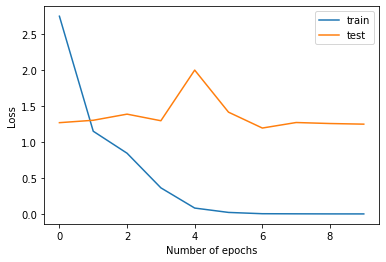

In [22]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.show()

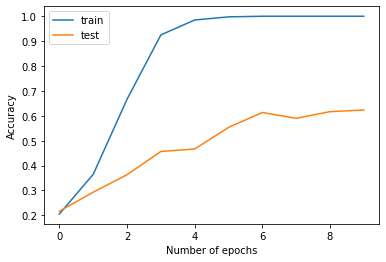

In [23]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

**Plot model**

In [1]:
# plot_model(loaded_model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

**Load model**

In [12]:
# The model weights and architecture were saved separated, so it must re-compile

# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loaded model from disk


In [13]:
# Evaluate loaded model on test data

# Compile
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Display accuracy
_, acc = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy: %.2f%%' % (acc*100))

c:\users\flucasamar\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Accuracy: 41.67%
